In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyscf import scf
from ase.io import read
from ase.units import Hartree, mol, kcal
from ase import Atoms

In [2]:
kcal_mol = kcal/mol
kcal_mol
Hart_to_kcalmol = Hartree/kcal_mol
figp = '/home/awills/Documents/Research/figs/ml'

# August 23 Meeting

Broad overview -- try atomization energies using the single atom energy references but from the CCSD(T) calculation energies, not the reference atomization energies. Need to find the error in `pred_atm.dat` printing that prints the total energies as opposed to the atomization energies. Need to use a model good for total energies (and soon, atomization energies) to see the Eref vs Epred (both total and atomization), as well as xcdiff, pre-trained SCAN model, and the model taught with default settings. Also need to check Sebastian's CCSD(T) energies to see if they align with mine.

 - Check Sebastian's CCSD(T) energies and plot against mine
 - Check plot of G2/97 Atomization Energies vs. CCSD(T) Atomization Energies (both using the single-atom reference energies)
 - Plot (Eref,Epred), total and atomization, for:
     - XCDiff
     - PT SCAN
     - Model with default settings
     - Model with "good" total energy predictions

#### First check -- density matrix shapes in Sebastian's "reference data" folder

In [3]:
srp = '/home/awills/Documents/Research/xcdiff/data/ref/6-311'
srpdms = sorted([i for i in os.listdir(srp) if 'dm' in i], key = lambda x: int(x.split('.')[0]))
for dmp in srpdms:
    dm = np.load(os.path.join(srp, dmp))
    print(dm.shape)

(2, 30, 30)
(2, 78, 78)
(2, 78, 78)
(2, 93, 93)
(2, 117, 117)
(2, 94, 94)
(2, 78, 78)
(2, 78, 78)
(2, 108, 108)
(2, 78, 78)
(2, 62, 62)
(2, 54, 54)
(2, 94, 94)
(2, 39, 39)
(2, 47, 47)
(2, 39, 39)
(2, 15, 15)
(2, 39, 39)
(2, 39, 39)
(2, 47, 47)
(2, 39, 39)
(2, 78, 78)
(2, 54, 54)
(2, 54, 54)


## ALL OF SEBASTIAN'S DENSITY MATRIX REFERENCES ARE POLARIZED, IGNORING CLOSED/OPEN OR INFO FLAGS THAT INDICATE UNPOLARIZED.

#### Sebastian's CCSD(T) energies against mine

In [4]:
sebep = '/home/awills/Documents/Research/xcdiff/data/ccsdt'
seben = np.loadtxt(os.path.join(sebep, 'progress'))
alp = '/home/awills/Documents/Research/swxcd/seawulf/g297/'
sebdm = sorted([i for i in os.listdir(sebep) if 'dm' in i and '_' not in i], key = lambda x: int(x.split('.')[0]))
aldm = sorted([i for i in os.listdir(alp) if 'dm' in i] , key = lambda x: int(x.split('_')[0]))


alen = pd.read_csv('/home/awills/Documents/Research/swxcd/seawulf/g297/progress', delimiter='\t')
xcd = read('/home/awills/Documents/Research/swxcd/aegis/xcd_ccsdt/calc_results.traj', ':')
alen.columns = [i.strip() for i in alen.columns]
alen['atoms.symbols'] = alen['atoms.symbols'].str.strip()
altrj = read('/home/awills/Documents/Research/swxcd/seawulf/g297/results.traj', ':')
#results.traj file completely useless, some random collection of molecules that aren't even the whole dataset.
#sebt = read(os.path.join(sebep, 'results.traj'), ':')
chkpts = sorted([i for i in os.listdir(sebep) if 'chkpt' in i], key = lambda x: int(x.split('.')[0]))
atoms = []
maxdmes = []
meandmes = []
sumdmes = []
for idx, ic in enumerate(chkpts):
    tmp = scf.chkfile.load_scf(os.path.join(sebep, ic))
    atom = tmp[0].atom
    astr = ''.join([at[0] for at in atom])
    apos = [at[1] for at in atom]
    atobj = Atoms(astr, positions = apos)
    atobj.info['energy'] = seben[idx]
    atoms.append(Atoms(astr, positions = apos))
    
    adm = np.load(os.path.join(alp, aldm[idx]))
    sdm = np.load(os.path.join(sebep, sebdm[idx]))
    
    if len(sdm.shape) > len(adm.shape):
        #average polarizations
        sdm = (sdm[0] + sdm[1])/2
    
    #print(adm.shape, sdm.shape)
    maxdmes.append(np.max(adm-sdm))
    meandmes.append(np.mean(adm-sdm))
    sumdmes.append(np.sum(abs(adm-sdm)))
    
cols = alen.columns
symbs = [str(at.symbols) for at in atoms]
xcdsym = [str(at.symbols) for at in xcd]
ordes = np.array([alen[alen['atoms.symbols'] == sym][cols[2]].values[0] for sym in symbs])

/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/ase/io/jsonio.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array(obj)


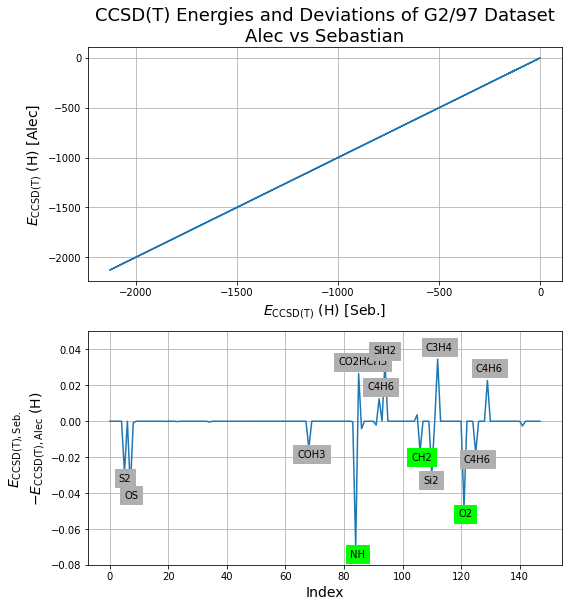

In [5]:
f = plt.figure(figsize=(8,12))
eax = f.add_subplot(311)
dax = f.add_subplot(312)
axes = [eax,dax]
dev = seben[:, 1]-ordes
eax.plot(seben[:, 1], ordes)
dax.plot(dev)

for ax in axes:
    ax.grid()
for idx, d in enumerate(dev):
    if abs(d) > 0.01:
        if symbs[idx] in xcdsym:
            dax.annotate(symbs[idx], (idx-len(symbs[idx]), d+np.sign(d)*0.005),
                        backgroundcolor="#00ff00")
        else:
            dax.annotate(symbs[idx], (idx-len(symbs[idx]), d+np.sign(d)*0.005),
                        backgroundcolor="#afafaf")

eax.set_ylabel('$E_\mathrm{CCSD(T)}$ (H) [Alec]', fontsize=14)
eax.set_xlabel('$E_\mathrm{CCSD(T)}$ (H) [Seb.]', fontsize=14)

dax.set_xlabel('Index', fontsize=14)
dax.set_ylabel('$E_\mathrm{CCSD(T),Seb.}$\n$- E_\mathrm{CCSD(T),Alec}$ (H)', fontsize=14)

dax.set_ylim(-0.08, 0.05)

eax.set_title('CCSD(T) Energies and Deviations of G2/97 Dataset\nAlec vs Sebastian', fontsize=18)

plt.tight_layout()

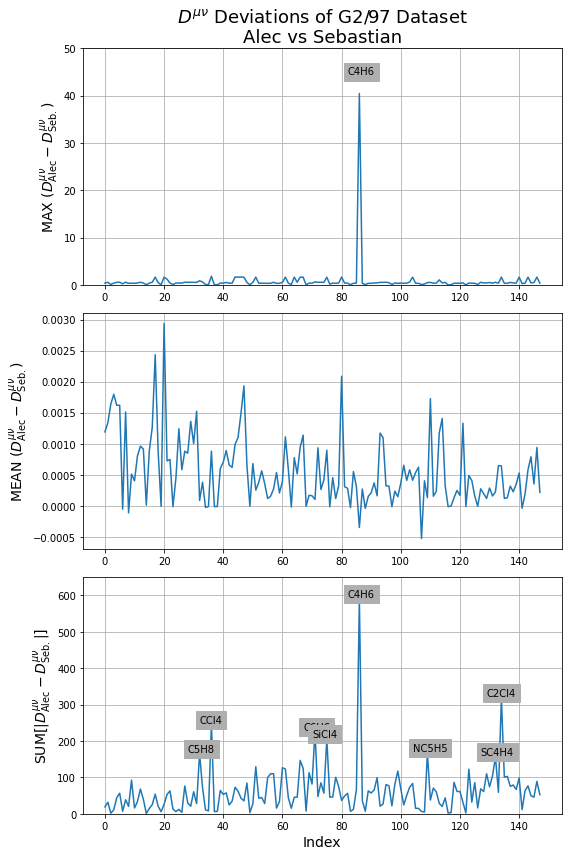

In [6]:
f = plt.figure(figsize=(8,12))
dmax = f.add_subplot(311)
dmean = f.add_subplot(312, sharex=dmax)
dsum = f.add_subplot(313, sharex=dmean)
axes = [dmax,dmean,dsum]
dmax.plot(maxdmes)
dmean.plot(meandmes)
dsum.plot(sumdmes)
for ax in axes[:3]:
    ax.grid()

dmax.set_ylim(0, 50)
for idx, d in enumerate(maxdmes):
    if d > 2:
        if symbs[idx] in xcdsym:
            dmax.annotate(symbs[idx], (idx-len(symbs[idx]), d+len(symbs[idx])*np.sign(d)*1),
                        backgroundcolor="#00ff00", alpha=0.01)
        else:
            dmax.annotate(symbs[idx], (idx-len(symbs[idx]), d+len(symbs[idx])*np.sign(d)*1),
                        backgroundcolor="#afafaf")

dsum.set_ylim(0, 650)
for idx, d in enumerate(sumdmes):
    if d > 150:
        if symbs[idx] in xcdsym:
            dsum.annotate(symbs[idx], (idx-len(symbs[idx]), d+len(symbs[idx])*np.sign(d)*1),
                        backgroundcolor="#00ff00", alpha=0.01)
        else:
            dsum.annotate(symbs[idx], (idx-len(symbs[idx]), d+len(symbs[idx])*np.sign(d)*1),
                        backgroundcolor="#afafaf")

            
            
dmax.set_ylabel('MAX $(D^{\mu\\nu}_\mathrm{Alec} - D^{\mu\\nu}_\mathrm{Seb.})$', fontsize=14)
dmean.set_ylabel('MEAN $(D^{\mu\\nu}_\mathrm{Alec} - D^{\mu\\nu}_\mathrm{Seb.})$', fontsize=14)
dsum.set_ylabel('SUM[$|D^{\mu\\nu}_\mathrm{Alec} - D^{\mu\\nu}_\mathrm{Seb.}|$]', fontsize=14)
dsum.set_xlabel('Index', fontsize=14)

dmax.set_title('$D^{\mu\\nu}$ Deviations of G2/97 Dataset\nAlec vs Sebastian', fontsize=18)


plt.tight_layout()

#### Check plot of G2/97 Atomization Energies vs. CCSD(T) Atomization Energies (both using the single-atom reference energies)

Atomic energies taken from Table XI in [this paper](https://doi.org/10.1103/PhysRevA.47.3649), from the column corresponding to the neutral atom. These are indices 13-20 in the reaction trajectory. Reference atomization energies in the trajectory are in eV.

In [7]:
from ase.units import Hartree

sat = read('/home/awills/Documents/Research/xcdiff/data/haunschild_g2/single_atoms.traj', ':')
g2traj = read('/home/awills/Documents/Research/xcdiff/data/haunschild_g2/g2_97.traj', ':')
atend = {str(at.symbols):0 for at in sat}
atend['Al'] = -242.346
atend['B'] = -24.65391
atend['Be'] = -14.66736
atend['C'] = -37.8450
atend['Cl'] = -460.148
atend['F'] = -99.7339
atend['H'] = -0.5
atend['Li'] = -7.47806
atend['N'] = -54.5892
atend['Na'] = -162.2546
atend['O'] = -75.0673
atend['P'] = -341.259
atend['S'] = -398.110
atend['Si'] = -289.359

accsdt_aes = []
sccsdt_aes = []
ref_aes = []
for idx, at in enumerate(altrj):
    syms = at.get_chemical_symbols()
    e = at.calc.results['energy']
    se = seben[idx][1]
    for s in syms:
        e -= atend[s]
        se -= atend[s]
    print(at.symbols, e)
    accsdt_aes.append(e)
    sccsdt_aes.append(se)
    
    refat = g2traj[idx].calc.results['energy']/Hartree
    ref_aes.append(-refat)
    
ref_aes = np.array(ref_aes)
accsdt_aes = np.array(accsdt_aes)
sccsdt_aes = np.array(sccsdt_aes)

OC -0.2894302177705441
CS 0.08085816388268086
H2 -0.17234886811845662
FH -0.130822297559547
P2 0.3869915500405341
S2 0.4760810265937607
SH 0.16439910105356148
OS 0.21971958565660543
C2H -0.3227352923141211
CF4 -0.3388925791515476
CH4 -0.6164480442492533
CO2 -0.422158757033543
SCS 0.21348518927231908
FOF 0.12099032758523265
BeH -0.045726658834585265
OH2 -0.2931017426835183
SH2 0.013978715164569167
Cl2 0.7001087762583893
CNH -0.3875540437589322
COH -0.3196048756290111
ClH 0.2245460493787732
N2O -0.23331445619344038
NF3 0.016414043599240813
NO2 -0.14917985889360352
Li2 0.022839082283955037
LiF -0.09398205221793887
LiH -0.06001992441894988
PF3 0.0005890179373295723
PH3 -0.09819286124314885
Na2 0.47703222296445347
SO2 0.05342072484316418
SiO 0.04408323028430061
C5H8 -1.7939714355134413
C3H4 -0.9681473006729107
C2H3 -0.6078488589864719
C2H5 -0.8587004582890927
CCl4 1.1249779317910225
COH3 -0.5106993298513487
CSH3 -0.25272142994867863
CHF3 -0.4007282967688184
OCF2 -0.3574228886642743
AlF3 -0.

/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/ase/io/jsonio.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array(obj)


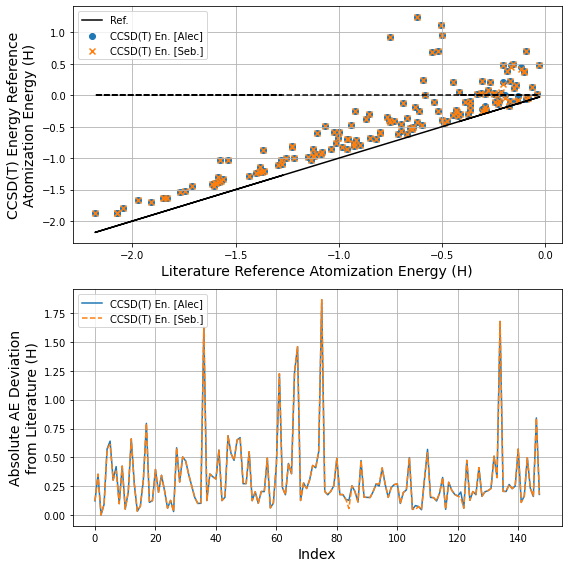

In [8]:
f = plt.figure(figsize=(8,8))
eax = f.add_subplot(211)
dax = f.add_subplot(212)
adev = abs(ref_aes - accsdt_aes)
sdev = abs(ref_aes - sccsdt_aes)

eax.plot(ref_aes, ref_aes, 'k-', label='Ref.')
eax.plot(ref_aes, np.zeros_like(ref_aes), 'k--')
eax.scatter(ref_aes, accsdt_aes, label='CCSD(T) En. [Alec]')
eax.scatter(ref_aes, sccsdt_aes, marker='x', label='CCSD(T) En. [Seb.]')

dax.plot(adev, label='CCSD(T) En. [Alec]')
dax.plot(sdev, '--', label='CCSD(T) En. [Seb.]')

dax.grid()
eax.grid()

eax.set_xlabel("Literature Reference Atomization Energy (H)",fontsize=14)
eax.set_ylabel('CCSD(T) Energy Reference\nAtomization Energy (H)', fontsize=14)

dax.set_xlabel('Index', fontsize=14)
dax.set_ylabel('Absolute AE Deviation\nfrom Literature (H)', fontsize=14)

eax.legend()
dax.legend(loc='upper left')

plt.tight_layout()


#### Plot the various models total/AE energies against references (CCSD(T) total and G2/97 atomization), XCDiff.

In [9]:
def read_eval_table(path, epred = 2, eref = 3, aepred = 5, aeref = 6,
                   aerefmult = -1, scale=1):
    tab = pd.read_csv(path, delimiter = '\t')
    tab.columns = [i.strip() for i in tab.columns]
    tcol = tab.columns
    
    aey = tab[tcol[aepred]].values*scale
    ey = tab[tcol[epred]].values*scale
    
    e_err = np.mean( np.sqrt( (tab[tcol[epred]] - tab[tcol[eref]])**2 ) )*scale
    ae_err = np.mean( np.sqrt( (tab[tcol[aepred]] - (aerefmult*tab[tcol[aeref]]) )**2 ) )*scale
    
    return (tab, ey, aey, e_err, ae_err)

xcdg2 = pd.read_csv('/home/awills/Documents/Research/swxcd/eval/xcdiff_orig/MODEL_MGGA/g2/table.dat',
                   delimiter='\t')
xcdg2.columns = [i.strip() for i in xcdg2.columns]
xcdcol = xcdg2.columns
#negative needed in front, the printing assumed that the ref was positive when it is not
xcdaemse = np.mean(np.sqrt( (xcdg2[xcdcol[5]] - (-1*xcdg2[xcdcol[6]]))**2 ))
xcdemse = np.mean(np.sqrt( (xcdg2[xcdcol[2]] - (1*xcdg2[xcdcol[3]]))**2 ))

In [10]:
scale=Hart_to_kcalmol
ptst, ptsey, ptsaey, ptsee, ptsaee = read_eval_table('/home/awills/Documents/Research/swxcd/eval/ptscan/g297/table.dat', scale=scale)
ptsct, ptscey, ptscaey, ptscee, ptscaee = read_eval_table('/home/awills/Documents/Research/swxcd/eval/xcdset/pts2/MODEL_MGGA_e02/g2/table.dat', scale=scale)
xcdg2, xcdey, xcdaey, xcdee, xcdaee = read_eval_table('/home/awills/Documents/Research/swxcd/eval/xcdiff_orig/MODEL_MGGA/g2/table.dat', scale=scale)
pet, peey, peaey, peee, peaee = read_eval_table('/home/awills/Documents/Research/swxcd/eval/xcdset/pts_e100/MODEL_MGGA_e24/g2/table.dat', scale=scale)
pea11t, pea11ey, pea11aey, pea11ee, pea11aee = read_eval_table('/home/awills/Documents/Research/swxcd/eval/xcdset/pts_e100_ae100/MODEL_MGGA_e01/g2/table.dat', scale=scale)
pelat, pelaey, pelaaey, pelaee, pelaaee = read_eval_table('/home/awills/Documents/Research/swxcd/eval/xcdset/pts_el100_ae100/MODEL_MGGA_e10/g2/table.dat', scale=scale)

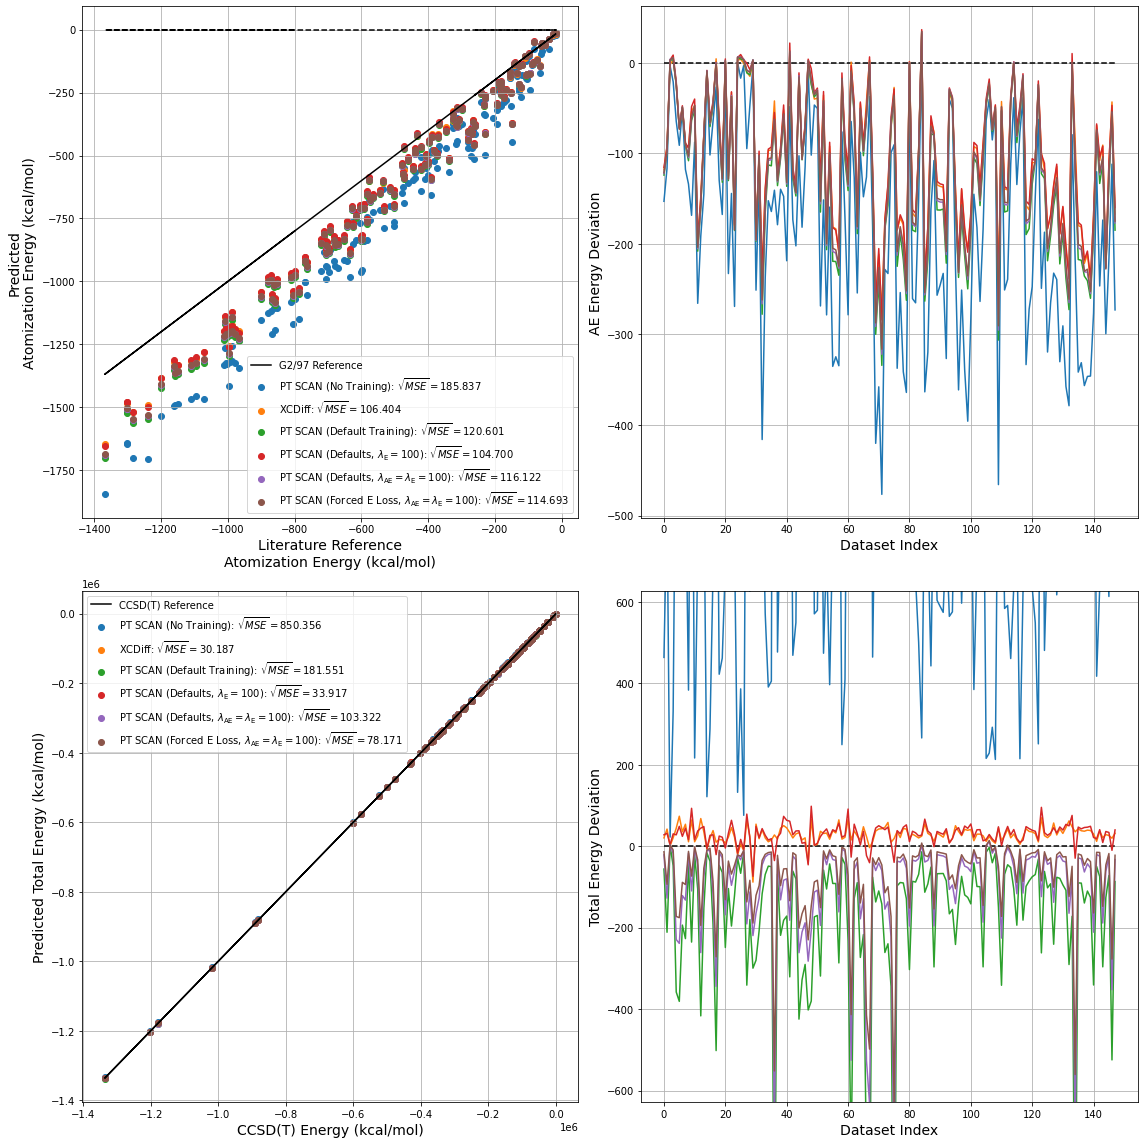

In [11]:
f = plt.figure(figsize=(16,16))
eax = f.add_subplot(221)
dax = f.add_subplot(223)

ddax = f.add_subplot(222)
edax = f.add_subplot(224)

ref_aes = ref_aes*scale
ordes = ordes*scale

eax.plot(ref_aes, ref_aes, 'k-', label='G2/97 Reference')
eax.plot(ref_aes, np.zeros_like(ref_aes), 'k--')

dax.plot(ordes, ordes, 'k-', label='CCSD(T) Reference')

eax.scatter(ref_aes, ptsaey, label='PT SCAN (No Training): $\sqrt{MSE} = $'+'{:4.3f}'.format(ptsaee))
eax.scatter(ref_aes, xcdaey, label='XCDiff: $\sqrt{MSE} = $'+'{:4.3f}'.format(xcdaee))
eax.scatter(ref_aes, ptscaey, label='PT SCAN (Default Training): $\sqrt{MSE} = $'+'{:4.3f}'.format(ptscaee))
eax.scatter(ref_aes, peaey, label='PT SCAN (Defaults, $\lambda_\mathrm{E} = 100$): $\sqrt{MSE} = $'+'{:4.3f}'.format(peaee))
eax.scatter(ref_aes, pea11aey, label='PT SCAN (Defaults, $\lambda_\mathrm{AE} = \lambda_\mathrm{E} = 100$): $\sqrt{MSE} = $'+'{:4.3f}'.format(pea11aee))
eax.scatter(ref_aes, pelaaey, label='PT SCAN (Forced E Loss, $\lambda_\mathrm{AE} = \lambda_\mathrm{E} = 100$): $\sqrt{MSE} = $'+'{:4.3f}'.format(pelaaee))

dax.scatter(ordes, ptsey, label='PT SCAN (No Training): $\sqrt{MSE} = $'+'{:4.3f}'.format(ptsee))
dax.scatter(ordes, xcdey, label='XCDiff: $\sqrt{MSE} = $'+'{:4.3f}'.format(xcdee))
dax.scatter(ordes, ptscey, label='PT SCAN (Default Training): $\sqrt{MSE} = $'+'{:4.3f}'.format(ptscee))
dax.scatter(ordes, peey, label='PT SCAN (Defaults, $\lambda_\mathrm{E} = 100$): $\sqrt{MSE} = $'+'{:4.3f}'.format(peee))
dax.scatter(ordes, pea11ey, label='PT SCAN (Defaults, $\lambda_\mathrm{AE} = \lambda_\mathrm{E} = 100$): $\sqrt{MSE} = $'+'{:4.3f}'.format(pea11ee))
dax.scatter(ordes, pelaey, label='PT SCAN (Forced E Loss, $\lambda_\mathrm{AE} = \lambda_\mathrm{E} = 100$): $\sqrt{MSE} = $'+'{:4.3f}'.format(pelaee))

ddax.plot(np.zeros_like(ref_aes), 'k--')
ddax.plot(ptsaey - ref_aes, label='PT SCAN (No Training): $\sqrt{MSE} = $'+'{:4.3f}'.format(ptsaee))
ddax.plot(xcdaey - ref_aes, label='XCDiff: $\sqrt{MSE} = $'+'{:4.3f}'.format(xcdaee))
ddax.plot(ptscaey - ref_aes, label='PT SCAN (No Training): $\sqrt{MSE} = $'+'{:4.3f}'.format(ptsaee))
ddax.plot(peaey - ref_aes)
ddax.plot(pea11aey - ref_aes)
ddax.plot(pelaaey - ref_aes)

edax.plot(np.zeros_like(ordes), 'k--')
edax.plot(ptsey - ordes)
edax.plot(xcdey - ordes)
edax.plot(ptscey - ordes)
edax.plot(peey - ordes)
edax.plot(pea11ey - ordes)
edax.plot(pelaey - ordes)

dax.grid()
ddax.grid()
eax.grid()
edax.grid()

units = 'kcal/mol'
#units = 'H'

eax.set_xlabel("Literature Reference\nAtomization Energy ({})".format(units),fontsize=14)
eax.set_ylabel('Predicted\nAtomization Energy ({})'.format(units), fontsize=14)

dax.set_xlabel('CCSD(T) Energy ({})'.format(units), fontsize=14)
dax.set_ylabel('Predicted Total Energy ({})'.format(units), fontsize=14)

ddax.set_xlabel('Dataset Index', fontsize=14)
ddax.set_ylabel('AE Energy Deviation', fontsize=14)
edax.set_xlabel('Dataset Index', fontsize=14)
edax.set_ylabel('Total Energy Deviation', fontsize=14)

edax.set_ylim(-1*scale, 1*scale)

eax.legend()
dax.legend()

plt.tight_layout()
plt.savefig(os.path.join(figp, 'checks_{}.png'.format(units.split('/')[0])), dpi=800)

In [12]:
peaey

array([ -375.34719996,  -265.05973   ,  -106.10801447,  -133.16007842,
        -137.45674397,  -175.43600306,  -135.00595105,  -215.01198869,
        -359.61541698,  -527.63763794,  -460.13423348,  -584.77783931,
        -430.62063196,  -172.46806391,   -59.09149363,  -294.65700099,
        -226.33798208,   -58.73362497,  -376.02321869,  -401.02674737,
        -103.13571111,  -391.8369478 ,  -238.39043375,  -406.55332434,
         -18.27605426,  -130.44935   ,   -54.41239575,  -366.35453238,
        -249.53534832,   -14.52354139,  -450.42933712,  -290.92224298,
       -1519.72493654,  -842.32879546,  -540.97779795,  -696.84203644,
        -370.10432527,  -522.46446907,  -476.83245647,  -506.57499065,
        -543.33119713,  -410.27579699,  -490.34662572,  -406.41047081,
        -139.50836773,  -294.09225627,  -234.23201634,   -94.65066909,
        -584.72860319,  -260.9933496 ,  -352.45847837, -1121.58989627,
        -469.72664372,  -690.92309851,  -651.46238111, -1331.66456261,
      

The model where energy loss is forced, and both the Ew and AEw are 100. Find best -- unambiguously epoch 10 is best on the G2/97 Dataset.

Current En Err: 0.24856477151115652. Current AE Err: 0.18654288835729801. Epoch 00.
Min En Err: 0.24856477151115652, Epoch: 00
Min AE Err: 0.18654288835729801, Epoch: 00
Current En Err: 0.18215809969585398. Current AE Err: 0.18429505218231015. Epoch 01.
Min En Err: 0.18215809969585398, Epoch: 01
Min AE Err: 0.18429505218231015, Epoch: 01
Current En Err: 0.15676169515480937. Current AE Err: 0.1833199942029858. Epoch 02.
Min En Err: 0.15676169515480937, Epoch: 02
Min AE Err: 0.1833199942029858, Epoch: 02
Current En Err: 0.1503348627377524. Current AE Err: 0.18327132892682774. Epoch 03.
Min En Err: 0.1503348627377524, Epoch: 03
Min AE Err: 0.18327132892682774, Epoch: 03
Current En Err: 0.13414508199489436. Current AE Err: 0.18285011979247687. Epoch 07.
Min En Err: 0.13414508199489436, Epoch: 07
Min AE Err: 0.18285011979247687, Epoch: 07
Current En Err: 0.12977902969238603. Current AE Err: 0.18298595119070407. Epoch 09.
Min En Err: 0.12977902969238603, Epoch: 09
Current En Err: 0.124573810

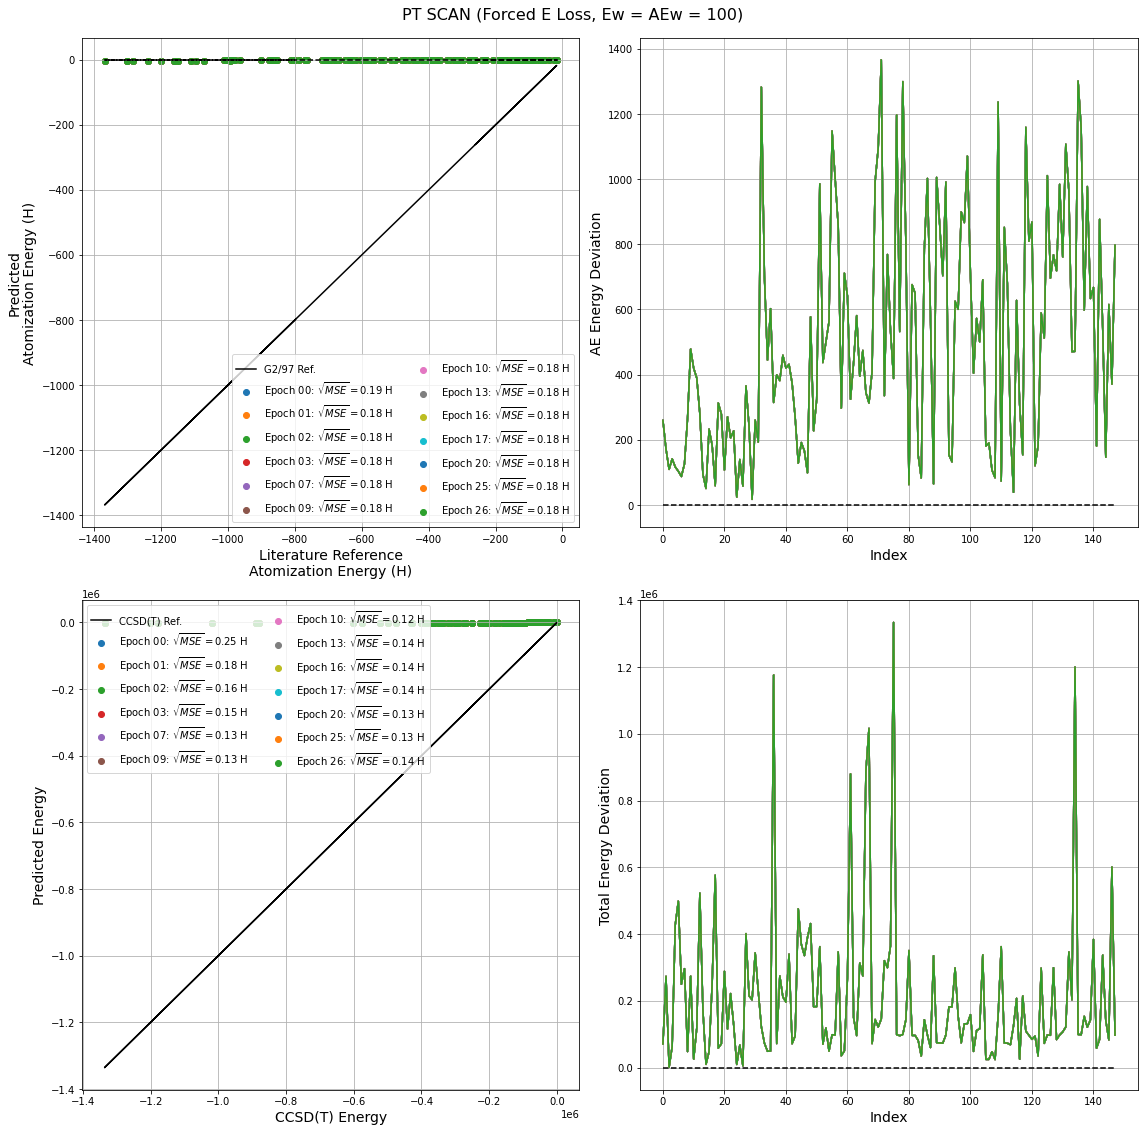

In [13]:
pelap = '/home/awills/Documents/Research/swxcd/eval/xcdset/pts_el100_ae100'
mps = sorted([i for i in os.listdir(pelap) if 'MODEL_MGGA' in i], key = lambda x: int(x.split('_')[-1][1:]) )

f = plt.figure(figsize=(16,16))
eax = f.add_subplot(221)
dax = f.add_subplot(223)

ddax = f.add_subplot(222)
edax = f.add_subplot(224)

eax.plot(ref_aes, ref_aes, 'k-', label='G2/97 Ref.')
eax.plot(ref_aes, np.zeros_like(ref_aes), 'k--')

dax.plot(ordes, ordes, 'k-', label='CCSD(T) Ref.')

ddax.plot(np.zeros_like(ref_aes),'k--')
edax.plot(np.zeros_like(ordes),'k--')

dax.grid()
eax.grid()
ddax.grid()
edax.grid()

eax.set_xlabel("Literature Reference\nAtomization Energy (H)",fontsize=14)
eax.set_ylabel('Predicted\nAtomization Energy (H)', fontsize=14)

dax.set_xlabel('CCSD(T) Energy', fontsize=14)
dax.set_ylabel('Predicted Energy', fontsize=14)

ddax.set_xlabel('Index', fontsize=14)
ddax.set_ylabel('AE Energy Deviation', fontsize=14)
edax.set_xlabel('Index', fontsize=14)
edax.set_ylabel('Total Energy Deviation', fontsize=14)


plt.tight_layout()
minee = 999999
minaee = 999999
eeep = ''
aeep = ''

for idx, mp in enumerate(mps):
    tp = os.path.join(pelap, mp, 'g2', 'table.dat')
    epoch = mp.split('_')[-1][1:]
    tab, tabey, tabaey, tabee, tabaee = read_eval_table(tp)
    minee = tabee if tabee < minee else minee
    minaee = tabaee if tabaee < minaee else minaee
    print("Current En Err: {}. Current AE Err: {}. Epoch {}.".format(tabee, tabaee, epoch))
    if minee == tabee:
        eeep = epoch
        print('Min En Err: {}, Epoch: {}'.format(minee, epoch))
    if minaee == tabaee:
        aeep = epoch
        print('Min AE Err: {}, Epoch: {}'.format(minaee, epoch))

    eax.scatter(ref_aes, tabaey, label='Epoch {}:'.format(epoch)+' $\sqrt{MSE} = $'+'{:3.2f} H'.format(tabaee))
    dax.scatter(ordes, tabey, label='Epoch {}:'.format(epoch)+' $\sqrt{MSE} = $'+'{:3.2f} H'.format(tabee))
    
    ddax.plot(tabaey - ref_aes)
    edax.plot(tabey - ordes)
    
    
    
    
eax.legend(ncol=2)
dax.legend(ncol=2, loc='upper left')

plt.suptitle('PT SCAN (Forced E Loss, Ew = AEw = 100)\n', fontsize=16)
plt.tight_layout()

For the defaults + Ew = 100, best AE err is last epoch (27), but best E err is epoch 24 (and another best AE occurs here, so use it over last)

Current En Err: 0.19914402005232093. Current AE Err: 0.18502543822482123. Epoch 00.
Best Min En Err: 0.19914402005232093, Epoch: 00
Best Min AE Err: 0.18502543822482123, Epoch: 00
Current En Err: 0.1178377959952152. Current AE Err: 0.18275567810360266. Epoch 01.
Best Min En Err: 0.1178377959952152, Epoch: 01
Best Min AE Err: 0.18275567810360266, Epoch: 01
Current En Err: 0.08290047106000972. Current AE Err: 0.18124942875204106. Epoch 02.
Best Min En Err: 0.08290047106000972, Epoch: 02
Best Min AE Err: 0.18124942875204106, Epoch: 02
Current En Err: 0.07442694506968951. Current AE Err: 0.17954541634090934. Epoch 03.
Best Min En Err: 0.07442694506968951, Epoch: 03
Best Min AE Err: 0.17954541634090934, Epoch: 03
Current En Err: 0.07507117335046828. Current AE Err: 0.17830904057334723. Epoch 04.
Best Min AE Err: 0.17830904057334723, Epoch: 04
Current En Err: 0.07484933576520138. Current AE Err: 0.17766110393633883. Epoch 05.
Best Min AE Err: 0.17766110393633883, Epoch: 05
Current En Err: 0.

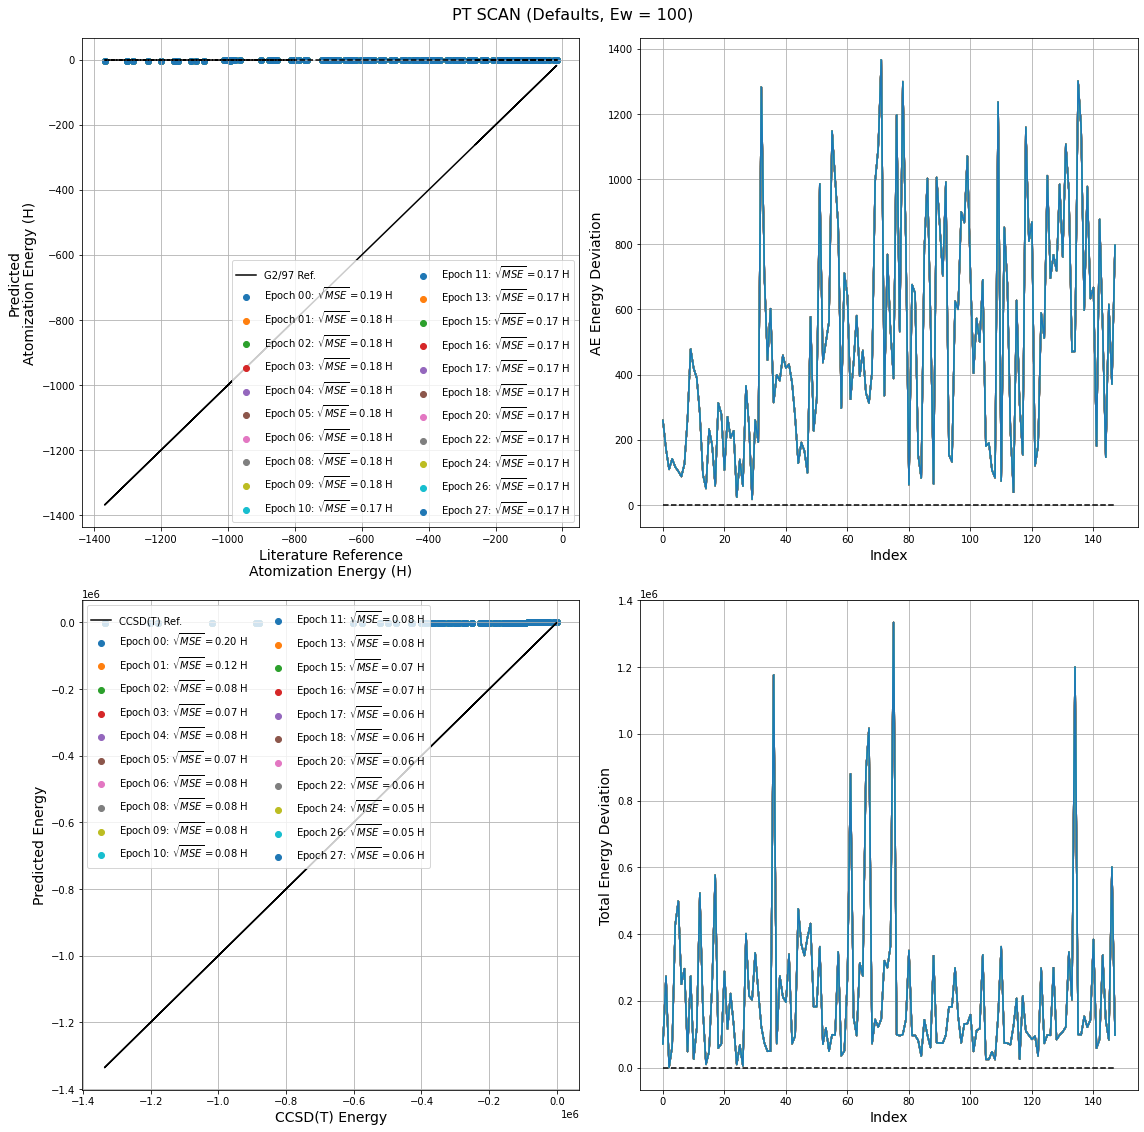

In [14]:
pep = '/home/awills/Documents/Research/swxcd/eval/xcdset/pts_e100'
mps = sorted([i for i in os.listdir(pep) if 'MODEL_MGGA' in i], key = lambda x: int(x.split('_')[-1][1:]) )

f = plt.figure(figsize=(16,16))
eax = f.add_subplot(221)
dax = f.add_subplot(223)

ddax = f.add_subplot(222)
edax = f.add_subplot(224)

eax.plot(ref_aes, ref_aes, 'k-', label='G2/97 Ref.')
eax.plot(ref_aes, np.zeros_like(ref_aes), 'k--')

dax.plot(ordes, ordes, 'k-', label='CCSD(T) Ref.')

ddax.plot(np.zeros_like(ref_aes),'k--')
edax.plot(np.zeros_like(ordes),'k--')

dax.grid()
eax.grid()
ddax.grid()
edax.grid()

eax.set_xlabel("Literature Reference\nAtomization Energy (H)",fontsize=14)
eax.set_ylabel('Predicted\nAtomization Energy (H)', fontsize=14)

dax.set_xlabel('CCSD(T) Energy', fontsize=14)
dax.set_ylabel('Predicted Energy', fontsize=14)

ddax.set_xlabel('Index', fontsize=14)
ddax.set_ylabel('AE Energy Deviation', fontsize=14)
edax.set_xlabel('Index', fontsize=14)
edax.set_ylabel('Total Energy Deviation', fontsize=14)


plt.tight_layout()

minee = 999999
minaee = 999999
eeep = ''
aeep = ''
for idx, mp in enumerate(mps):
    tp = os.path.join(pep, mp, 'g2', 'table.dat')
    epoch = mp.split('_')[-1][1:]
    tab, tabey, tabaey, tabee, tabaee = read_eval_table(tp)
    minee = tabee if tabee < minee else minee
    minaee = tabaee if tabaee < minaee else minaee
    print("Current En Err: {}. Current AE Err: {}. Epoch {}.".format(tabee, tabaee, epoch))
    if minee == tabee:
        eeep = epoch
        print('Best Min En Err: {}, Epoch: {}'.format(minee, epoch))
    if minaee == tabaee:
        aeep = epoch
        print('Best Min AE Err: {}, Epoch: {}'.format(minaee, epoch))
    
    eax.scatter(ref_aes, tabaey, label='Epoch {}:'.format(epoch)+' $\sqrt{MSE} = $'+'{:3.2f} H'.format(tabaee))
    dax.scatter(ordes, tabey, label='Epoch {}:'.format(epoch)+' $\sqrt{MSE} = $'+'{:3.2f} H'.format(tabee))
    
    ddax.plot(tabaey - ref_aes)
    edax.plot(tabey - ordes)
    
    
    
    
eax.legend(ncol=2)
dax.legend(ncol=2, loc='upper left')

plt.suptitle('PT SCAN (Defaults, Ew = 100)\n', fontsize=16)
plt.tight_layout()

Look at defaults + Ew = AEw = 100. None of which do very good, but of them epoch 1 is the best.

Current En Err: 0.20960834751888957. Current AE Err: 0.18554421830622383. Epoch 00.
Best Min En Err: 0.20960834751888957, Epoch: 00
Best Min AE Err: 0.18554421830622383, Epoch: 00
Current En Err: 0.16465452847377463. Current AE Err: 0.1850517250148949. Epoch 01.
Best Min En Err: 0.16465452847377463, Epoch: 01
Best Min AE Err: 0.1850517250148949, Epoch: 01
Current En Err: 0.16493396151344664. Current AE Err: 0.18615956478022994. Epoch 02.
Current En Err: 0.17462195635874442. Current AE Err: 0.18753837553646824. Epoch 03.
Current En Err: 0.17175142913605843. Current AE Err: 0.18832527485992742. Epoch 04.
Current En Err: 0.1680292143583825. Current AE Err: 0.18868315956896914. Epoch 05.
Current En Err: 0.17299507893594357. Current AE Err: 0.1899391541772786. Epoch 06.
Current En Err: 0.18048408349371914. Current AE Err: 0.19232020043896336. Epoch 08.
Current En Err: 0.17575669710697736. Current AE Err: 0.19311139069232625. Epoch 09.
Current En Err: 0.17081939197183568. Current AE Err: 0.1

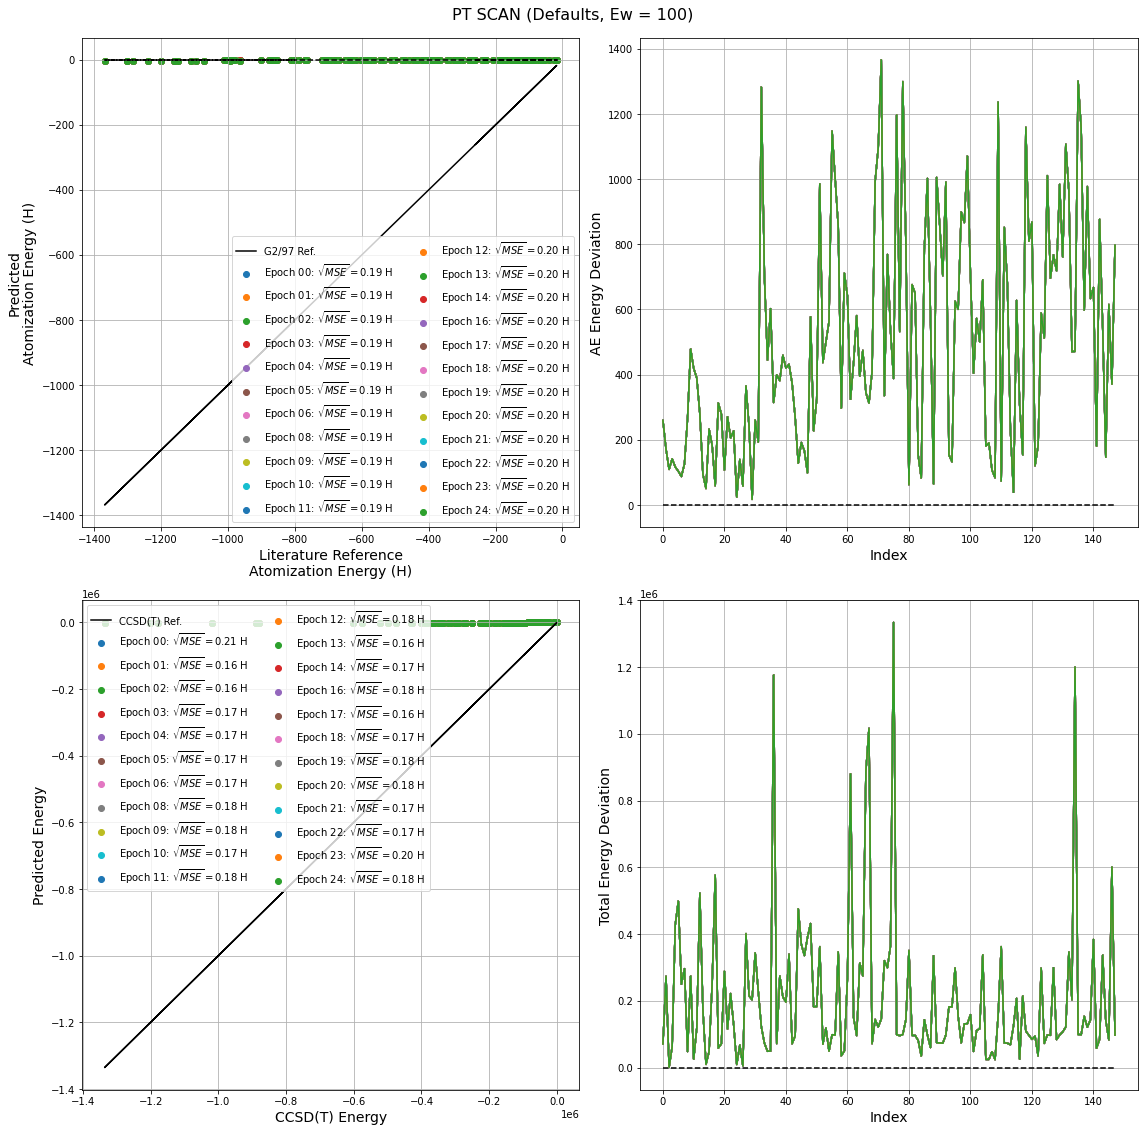

In [15]:
pep = '/home/awills/Documents/Research/swxcd/eval/xcdset/pts_e100_ae100'
mps = sorted([i for i in os.listdir(pep) if 'MODEL_MGGA' in i], key = lambda x: int(x.split('_')[-1][1:]) )

f = plt.figure(figsize=(16,16))
eax = f.add_subplot(221)
dax = f.add_subplot(223)

ddax = f.add_subplot(222)
edax = f.add_subplot(224)

eax.plot(ref_aes, ref_aes, 'k-', label='G2/97 Ref.')
eax.plot(ref_aes, np.zeros_like(ref_aes), 'k--')

dax.plot(ordes, ordes, 'k-', label='CCSD(T) Ref.')

ddax.plot(np.zeros_like(ref_aes),'k--')
edax.plot(np.zeros_like(ordes),'k--')

dax.grid()
eax.grid()
ddax.grid()
edax.grid()

eax.set_xlabel("Literature Reference\nAtomization Energy (H)",fontsize=14)
eax.set_ylabel('Predicted\nAtomization Energy (H)', fontsize=14)

dax.set_xlabel('CCSD(T) Energy', fontsize=14)
dax.set_ylabel('Predicted Energy', fontsize=14)

ddax.set_xlabel('Index', fontsize=14)
ddax.set_ylabel('AE Energy Deviation', fontsize=14)
edax.set_xlabel('Index', fontsize=14)
edax.set_ylabel('Total Energy Deviation', fontsize=14)


plt.tight_layout()

minee = 999999
minaee = 999999
eeep = ''
aeep = ''
for idx, mp in enumerate(mps):
    tp = os.path.join(pep, mp, 'g2', 'table.dat')
    epoch = mp.split('_')[-1][1:]
    tab, tabey, tabaey, tabee, tabaee = read_eval_table(tp)
    minee = tabee if tabee < minee else minee
    minaee = tabaee if tabaee < minaee else minaee
    print("Current En Err: {}. Current AE Err: {}. Epoch {}.".format(tabee, tabaee, epoch))
    if minee == tabee:
        eeep = epoch
        print('Best Min En Err: {}, Epoch: {}'.format(minee, epoch))
    if minaee == tabaee:
        aeep = epoch
        print('Best Min AE Err: {}, Epoch: {}'.format(minaee, epoch))
    
    eax.scatter(ref_aes, tabaey, label='Epoch {}:'.format(epoch)+' $\sqrt{MSE} = $'+'{:3.2f} H'.format(tabaee))
    dax.scatter(ordes, tabey, label='Epoch {}:'.format(epoch)+' $\sqrt{MSE} = $'+'{:3.2f} H'.format(tabee))
    
    ddax.plot(tabaey - ref_aes)
    edax.plot(tabey - ordes)
    
    
    
    
eax.legend(ncol=2)
dax.legend(ncol=2, loc='upper left')

plt.suptitle('PT SCAN (Defaults, Ew = 100)\n', fontsize=16)
plt.tight_layout()

For just training PT SCAN with defaults, epoch 2 best combined, although energies better later.

Current En Err: 0.289319164054458. Current AE Err: 0.19219016300207611. Epoch 02.
Best Min En Err: 0.289319164054458, Epoch: 02
Best Min AE Err: 0.19219016300207611, Epoch: 02
Current En Err: 0.2831286228434188. Current AE Err: 0.19321033738994403. Epoch 03.
Best Min En Err: 0.2831286228434188, Epoch: 03
Current En Err: 0.28737130557258533. Current AE Err: 0.19493516831407662. Epoch 04.
Current En Err: 0.2892978362962953. Current AE Err: 0.20792914027395293. Epoch 15.
Current En Err: 0.28178361274734465. Current AE Err: 0.2076767307255829. Epoch 16.
Best Min En Err: 0.28178361274734465, Epoch: 16
Current En Err: 0.27816096525242673. Current AE Err: 0.20898370380094144. Epoch 17.
Best Min En Err: 0.27816096525242673, Epoch: 17
Current En Err: 0.28853297958964425. Current AE Err: 0.21104854809012794. Epoch 19.
Current En Err: 0.2958904031131943. Current AE Err: 0.21248842800201284. Epoch 20.
Current En Err: 0.2900089225332715. Current AE Err: 0.21296640842650735. Epoch 21.


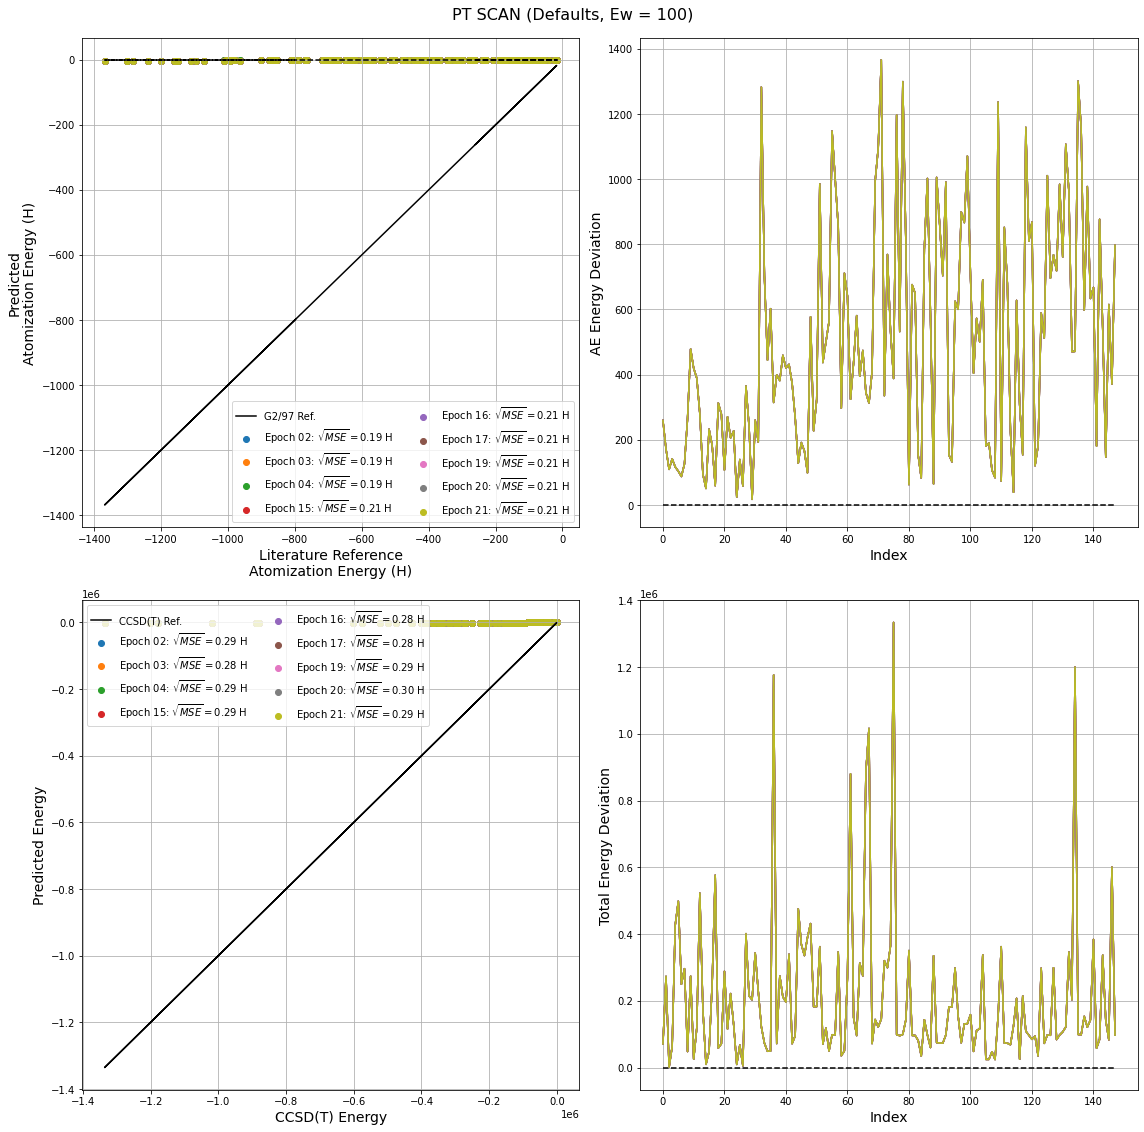

In [16]:
pep = '/home/awills/Documents/Research/swxcd/eval/xcdset/pts2'
mps = sorted([i for i in os.listdir(pep) if 'MODEL_MGGA' in i], key = lambda x: int(x.split('_')[-1][1:]) )

f = plt.figure(figsize=(16,16))
eax = f.add_subplot(221)
dax = f.add_subplot(223)

ddax = f.add_subplot(222)
edax = f.add_subplot(224)

eax.plot(ref_aes, ref_aes, 'k-', label='G2/97 Ref.')
eax.plot(ref_aes, np.zeros_like(ref_aes), 'k--')

dax.plot(ordes, ordes, 'k-', label='CCSD(T) Ref.')

ddax.plot(np.zeros_like(ref_aes),'k--')
edax.plot(np.zeros_like(ordes),'k--')

dax.grid()
eax.grid()
ddax.grid()
edax.grid()

eax.set_xlabel("Literature Reference\nAtomization Energy (H)",fontsize=14)
eax.set_ylabel('Predicted\nAtomization Energy (H)', fontsize=14)

dax.set_xlabel('CCSD(T) Energy', fontsize=14)
dax.set_ylabel('Predicted Energy', fontsize=14)

ddax.set_xlabel('Index', fontsize=14)
ddax.set_ylabel('AE Energy Deviation', fontsize=14)
edax.set_xlabel('Index', fontsize=14)
edax.set_ylabel('Total Energy Deviation', fontsize=14)


plt.tight_layout()

minee = 999999
minaee = 999999
eeep = ''
aeep = ''
for idx, mp in enumerate(mps):
    tp = os.path.join(pep, mp, 'g2', 'table.dat')
    epoch = mp.split('_')[-1][1:]
    tab, tabey, tabaey, tabee, tabaee = read_eval_table(tp)
    minee = tabee if tabee < minee else minee
    minaee = tabaee if tabaee < minaee else minaee
    print("Current En Err: {}. Current AE Err: {}. Epoch {}.".format(tabee, tabaee, epoch))
    if minee == tabee:
        eeep = epoch
        print('Best Min En Err: {}, Epoch: {}'.format(minee, epoch))
    if minaee == tabaee:
        aeep = epoch
        print('Best Min AE Err: {}, Epoch: {}'.format(minaee, epoch))
    
    eax.scatter(ref_aes, tabaey, label='Epoch {}:'.format(epoch)+' $\sqrt{MSE} = $'+'{:3.2f} H'.format(tabaee))
    dax.scatter(ordes, tabey, label='Epoch {}:'.format(epoch)+' $\sqrt{MSE} = $'+'{:3.2f} H'.format(tabee))
    
    ddax.plot(tabaey - ref_aes)
    edax.plot(tabey - ordes)
    
    
    
    
eax.legend(ncol=2)
dax.legend(ncol=2, loc='upper left')

plt.suptitle('PT SCAN (Defaults, Ew = 100)\n', fontsize=16)
plt.tight_layout()